In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from functools import reduce

from datasets.siim import SIIM
from data_processing.transforms import *

from appr0_VIT.model import VisionTransformer
from appr0_VIT.solver import Solver
from appr0_VIT.data_generator import DataGenerator

%load_ext autoreload
%autoreload 2

In [ ]:
'''
data generator - check what is wrong with yielding the last batch
---->  if i + 1 == len(self.dataset) and not self.drop_last:

optimize the solver (report accuracies different way)

stop controling the dataset (fixed 6 images)

understand logits from predictions + the behaviour of loss function
'''


In [2]:
hparams = {
        'batch_size': 2,
        'learning_rate': 1e-3,
        'epochs': 2,
        'loss_func': torch.nn.BCEWithLogitsLoss(),
        'optimizer': optim.AdamW,
        'patch_num': 8,
        'new_size': (3, 400, 600)
}

repo_root = os.path.abspath(os.getcwd())
model_root = os.path.join(repo_root, "trained_models")
data_root = os.path.join(repo_root, "data/siim")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed = 42
split = 0.7
num_classes = 2

transforms = [Patches(patch_num=hparams['patch_num']), Resize(new_size=hparams['new_size'])]

train = SIIM(root=data_root, purpose='train', seed=seed, split=split, transform=transforms)
val = SIIM(root=data_root, purpose='val', seed=seed, split=split, transform=transforms)

train_dataloader = DataGenerator(train, batch_size=hparams["batch_size"])
val_dataloader = DataGenerator(val, batch_size=hparams["batch_size"])

flattened_dim = reduce((lambda x, y: x * y), hparams['new_size'])

model = VisionTransformer(**{
                                'embed_dim': 256,
                                'hidden_dim': 512,
                                #'num_heads': 8,
                                #'num_layers': 6,
                                'num_heads': 4,
                                'num_layers': 2,
                                'flattened_dim': flattened_dim,
                                'num_patches': hparams['patch_num']**2,
                                'num_classes': num_classes,
                                'dropout': 0.2,
                                'hparams': hparams
                            })

patience = 10

solver = Solver(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    device=device,
    patience=patience
)

solver.train()

e:\!LMU\PythonProjects\generaldsvenv\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 8000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
e:\!LMU\PythonProjects\generaldsvenv\lib\site-packages\torch\nn\functional.py:3060: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


0 1 0 1
0 1 2 1
Train loss after epoch 1: 0.9678514003753662
0 1 0 1
Val loss after epoch 1: 0.4141588807106018
0 1 0 1
0 3 0 1
Train loss after epoch 2: 0.3252723316351573
0 1 0 1
Val loss after epoch 2: 0.7359344363212585
FINISH.


In [4]:
solver.train_TN_history

[1, 3]

In [1]:
!python appr0_train_SIIM.py

0 2 0 0

e:\!LMU\PythonProjects\generaldsvenv\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 8000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
e:\!LMU\PythonProjects\generaldsvenv\lib\site-packages\torch\nn\functional.py:3060: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "



0 3 0 1
Train loss after epoch 1: 0.7983382145563761
0 1 0 1
Val loss after epoch 1: 0.5482728481292725
0 1 0 1
0 1 2 1
Train loss after epoch 2: 0.682038426399231
0 0 1 1
Val loss after epoch 2: 0.38076314330101013
FINISH.
Saving model... e:\!LMU\PythonProjects\cv_attention\cv_attention\trained_models\vitmodel_batch2_lr0.001_epochs2.model


In [7]:
import pandas as pd

data = {
    'epoch': [i+1 for i in range(len(solver.train_loss_history))],
    'train_loss': solver.train_loss_history,
    'val_loss': solver.val_loss_history,
    'train_TP': solver.train_TP_history,
    'train_FP': solver.train_FP_history,
    'train_TN': solver.train_TN_history,
    'train_FN': solver.train_FN_history,
    'val_TP': solver.val_TP_history,
    'val_FP': solver.val_FP_history,
    'val_TN': solver.val_TN_history,
    'val_FN': solver.val_FN_history,
}

measurements = pd.DataFrame(data)
measurements['train_accuracy'] = (measurements['train_TP'] + measurements['train_TN']) / (measurements['train_TP'] + measurements['train_TN'] + measurements['train_FP'] + measurements['train_FN'])
measurements['train_recall'] = measurements['train_TP'] / (measurements['train_TP'] + measurements['train_FN'])
measurements['train_precision'] = measurements['train_TP'] / (measurements['train_TP'] + measurements['train_FP'])
measurements['train_f1'] = 2 * (measurements['train_recall'] * measurements['train_precision']) / (measurements['train_recall'] + measurements['train_precision'])
measurements['val_accuracy'] = (measurements['val_TP'] + measurements['val_TN']) / (measurements['val_TP'] + measurements['val_TN'] + measurements['val_FP'] + measurements['val_FN'])
measurements['val_recall'] = measurements['val_TP'] / (measurements['val_TP'] + measurements['val_FN'])
measurements['val_precision'] = measurements['val_TP'] / (measurements['val_TP'] + measurements['val_FP'])
measurements['val_f1'] = 2 * (measurements['val_recall'] * measurements['val_precision']) / (measurements['val_recall'] + measurements['val_precision'])

measurements.to_csv('', sep='|')

In [8]:
measurements.to_csv('', sep='|')

,epoch,train_loss,val_loss,train_TP,train_FP,train_TN,train_FN,val_TP,val_FP,val_TN,val_FN,train_accuracy,train_recall,train_precision,train_f1,val_accuracy,val_recall,val_precision,val_f1
0,1,0.967851,0.414159,0,2,1,1,0,0,1,1,0.25,0.0,0.0,NaN,0.5,0.0,NaN,NaN
1,2,0.325272,0.735934,0,0,3,1,0,0,1,1,0.75,0.0,NaN,NaN,0.5,0.0,NaN,NaN


In [8]:
sum(torch.tensor([1, 0]) == torch.tensor([1, 0]) == torch.tensor([1, 1]))

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [13]:
import math
def sigmoid(x):
    return 1/(1 + math.exp(-x))
    
math.exp(-0.1595) / (math.exp(-0.1595)+math.exp(-1.5360))

0.7984282966360959

In [11]:
math.exp(-1.5360) / (math.exp(-0.1595)+math.exp(-1.5360))

0.20157170336390395

In [12]:
predictions[:, 1]

tensor([-1.5360, -1.5978])

In [17]:
y=1
- (y*math.log(sigmoid(-1.5360)) + (1-y)*math.log(1-sigmoid(-1.5360)))

1.7309418705391069

In [18]:
y=0
- (y*math.log(sigmoid(-1.5978)) + (1-y)*math.log(1-sigmoid(-1.5978)))

0.18427063883414643

In [19]:
(1.7309418705391069+0.18427063883414643)/2

0.9576062546866266

In [9]:
predictions = torch.tensor([[-0.1595, -1.5360],
                            [-0.7603, -1.5978]])
labels = torch.tensor([1.0, 0.0])
criterion = torch.nn.BCEWithLogitsLoss()
criterion(predictions[:, 1].squeeze(), labels.float())

tensor(0.9576)

In [7]:
import math
math.exp(-0.0368)+math.exp(0.2213)

2.211566573579333

In [12]:
1 / (1 + np.exp(0.0368))

0.49080103811008197

In [14]:
1 / (1 + np.exp(-0.2213))

0.5551003112032241

In [2]:
hparams = {
    'batch_size': 1,
    'learning_rate': 1e-3,
    'epochs': 2,
    'loss_func': torch.nn.CrossEntropyLoss(),
    'optimizer': optim.AdamW
}

num_classes = 20
freeze=False
patience = 3
repo_root = os.path.abspath(os.getcwd())
data_root = os.path.join(repo_root, "data")
seed = 69
split = 0.7
patch_size = 16

transforms = [RescaleTransform(), ReshapeToTensor(), Patches(patch_size=patch_size), Resize()]
train = Cifar100(root=data_root, purpose='train', seed=seed, split=0.001, transform=transforms)
val = Cifar100(root=data_root, purpose='val', seed=seed, split=0.999, transform=transforms)

train_dataloader = DataGenerator(train, batch_size=hparams['batch_size'])
val_dataloader = DataGenerator(val, batch_size=hparams['batch_size'])
model = BaselineResNet(num_classes=num_classes, hparams=hparams, freeze=freeze)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

solver = BaselineSolver(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    device=device,
    patience=patience
)

solver.train()

os.makedirs('trained_models', exist_ok=True)
models_path = os.path.join(repo_root, 'trained_models')
model.save(os.path.join(models_path, f'baselinemodel_batch{hparams["batch_size"]}_lr{hparams["learning_rate"]}_epochs{hparams["epochs"]}_freeze{freeze}.model'))

'''
plt.title('Loss curves')
plt.plot(solver.train_loss_history, '-', label='train')
plt.plot(solver.val_loss_history, '-', label='val')
plt.legend(loc='lower right')
plt.xlabel('Iteration')
plt.show()

print("Training accuray: %.5f" % (solver.get_dataset_accuracy(dataloaders['train_overfit_single_image'])))
print("Validation accuray: %.5f" % (solver.get_dataset_accuracy(dataloaders['val_500files'])))
'''

e:\!LMU\PythonProjects\generaldsvenv\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 8000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


[Epoch 1, Iteration     5] loss: 2.68692
[Epoch 1, Iteration    10] loss: 4.53789
[Epoch 1, Iteration    15] loss: 4.01386
[Epoch 1, Iteration    20] loss: 4.49769
[Epoch 1, Iteration    25] loss: 3.55421
[Epoch 1, Iteration    30] loss: 3.56553
[Epoch 1, Iteration    35] loss: 4.65448
[Epoch 1, Iteration    40] loss: 3.48424
[Epoch 1, Iteration    45] loss: 3.35957
[Epoch 1, Iteration    50] loss: 4.12943
Training accuracy after epoch 1: 0.12999999523162842
Validation accuracy after epoch 1: 0.03999999910593033
[Epoch 2, Iteration     5] loss: 4.38255
[Epoch 2, Iteration    10] loss: 2.71874
[Epoch 2, Iteration    15] loss: 2.72712
[Epoch 2, Iteration    20] loss: 3.32118
[Epoch 2, Iteration    25] loss: 3.02486
[Epoch 2, Iteration    30] loss: 3.55531
[Epoch 2, Iteration    35] loss: 3.57472
[Epoch 2, Iteration    40] loss: 2.62976
[Epoch 2, Iteration    45] loss: 2.70567
[Epoch 2, Iteration    50] loss: 3.92151
Training accuracy after epoch 2: 0.10000000149011612
Validation accuracy

'\nplt.title(\'Loss curves\')\nplt.plot(solver.train_loss_history, \'-\', label=\'train\')\nplt.plot(solver.val_loss_history, \'-\', label=\'val\')\nplt.legend(loc=\'lower right\')\nplt.xlabel(\'Iteration\')\nplt.show()\n\nprint("Training accuray: %.5f" % (solver.get_dataset_accuracy(dataloaders[\'train_overfit_single_image\'])))\nprint("Validation accuray: %.5f" % (solver.get_dataset_accuracy(dataloaders[\'val_500files\'])))\n'

In [3]:
hparams = {
    'batch_size': 8,
    'learning_rate': 1e-2,
    'epochs': 1
}

model = ResNet(hparams=hparams)

repo_root = os.path.abspath(os.getcwd())
data_root = os.path.join(repo_root, "data")
seed = 69
split = 0.7

#CNN_model = torch.load(path)
#CNN_model = nn.Sequential(*(list(CNN_model.children())[:-2]))
#for param in CNN_model.parameters():
#    param.requires_grad = False
transforms = [RescaleTransform(), ReshapeToTensor(), Patches(patch_size=16), Resize()]#, PassThroughCNN(CNN_model)]

train = Cifar100(root=data_root, purpose='train', seed=seed, split=split, transform=transforms)
val = Cifar100(root=data_root, purpose='val', seed=seed, split=split, transform=transforms)
test = Cifar100(root=data_root, purpose='test', seed=seed, split=split, transform=transforms)

train_loader = DataGenerator(train, batch_size=model.hparams['batch_size'])
val_loader = DataGenerator(val, batch_size=model.hparams['batch_size'])

criterion = torch.nn.CrossEntropyLoss()
#remember to one hot encode labels!

optimizer = optim.AdamW(list(model.feature_extractor.parameters())+list(model.AdAvgP.parameters())+list(model.FC.parameters()), lr=model.hparams["learning_rate"])

train_loss_history = [] # loss
train_acc_history = [] # accuracy


for epoch in range(hparams['epochs']):
     
    running_loss = 0.0
 
    # Iterating through the minibatches of the data
    for i, batch in enumerate(train_loader):
        
        image, labels = batch['image'], batch['label']

        labels = torch.tensor(labels, dtype=torch.long)

        #labels_onehot = np.zeros((labels.size, model.num_classes))
        #labels_onehot[np.arange(labels.size), labels] = 1
        #labels_onehot = torch.tensor(labels_onehot)

        #image = image.to(device)
        #labels = labels.to(device)
 
        optimizer.zero_grad()              # Reset the parameter gradients  for the current  minibatch iteration
        predictions = model.forward(torch.tensor(image, dtype=torch.float32))         # Perform a forward pass on the network with inputs

        loss = criterion(predictions, labels) # calculate the loss with the network predictions and ground Truth
        loss.backward()             # Perform a backward pass to calculate the gradients
        optimizer.step()            # Optimize the network parameters with calculated gradients

        
        # Accumulate the loss and calculate the accuracy of predictions
        running_loss += loss.item()

        # Print statistics to console
        if i % 1 == 0: # print every 10 mini-batches
            running_loss /= 1
            print("[Epoch %d, Iteration %5d] loss: %.5f" % (epoch+1, i+1, running_loss))
            train_loss_history.append(running_loss)
            running_loss = 0.0

print('FINISH.')

[Epoch 1, Iteration     1] loss: 3.15119
[Epoch 1, Iteration     2] loss: 6.55386
[Epoch 1, Iteration     3] loss: 12.97375
[Epoch 1, Iteration     4] loss: 8.27364
[Epoch 1, Iteration     5] loss: 6.34709
[Epoch 1, Iteration     6] loss: 5.60924
[Epoch 1, Iteration     7] loss: 4.54106
[Epoch 1, Iteration     8] loss: 5.27723
[Epoch 1, Iteration     9] loss: 4.70683
[Epoch 1, Iteration    10] loss: 5.79413
[Epoch 1, Iteration    11] loss: 4.46769
[Epoch 1, Iteration    12] loss: 4.34472
[Epoch 1, Iteration    13] loss: 3.81410
[Epoch 1, Iteration    14] loss: 4.27671
[Epoch 1, Iteration    15] loss: 5.78943
[Epoch 1, Iteration    16] loss: 2.75463
[Epoch 1, Iteration    17] loss: 3.70401
[Epoch 1, Iteration    18] loss: 5.29587
[Epoch 1, Iteration    19] loss: 6.46343
[Epoch 1, Iteration    20] loss: 4.26429
[Epoch 1, Iteration    21] loss: 4.07189
[Epoch 1, Iteration    22] loss: 4.76640
[Epoch 1, Iteration    23] loss: 3.59940
[Epoch 1, Iteration    24] loss: 4.41170
[Epoch 1, Itera

KeyboardInterrupt: 

In [8]:
os.makedirs('trained_models', exist_ok=True)
model.save(os.path.join(repo_root, "trained_models\dummy_resnet.model"))

Saving model... e:\!LMU\PythonProjects\cv_attention\trained_models\dummy_resnet.model


In [26]:
train[1]

{'image': array([[[[0.03529412, 0.04313725, 0.05098039, ..., 0.04705882,
           0.04705882, 0.04705882],
          [0.03529412, 0.04313725, 0.04705882, ..., 0.04313725,
           0.05098039, 0.05882353],
          [0.03137255, 0.03921569, 0.04705882, ..., 0.0627451 ,
           0.06666667, 0.06666667],
          ...,
          [0.43529412, 0.56078431, 0.63137255, ..., 0.42352941,
           0.61960784, 0.69411765],
          [0.49019608, 0.54509804, 0.54901961, ..., 0.46666667,
           0.54509804, 0.50588235],
          [0.47843137, 0.44705882, 0.54509804, ..., 0.49019608,
           0.5372549 , 0.42745098]],
 
         [[0.1254902 , 0.13333333, 0.14117647, ..., 0.16862745,
           0.16862745, 0.16862745],
          [0.1372549 , 0.14509804, 0.14901961, ..., 0.18039216,
           0.17647059, 0.17647059],
          [0.14901961, 0.15686275, 0.16470588, ..., 0.19607843,
           0.19215686, 0.18823529],
          ...,
          [0.41960784, 0.56078431, 0.6       , ..., 0.4156

In [6]:
example_batch = next(iter(train_loader))
example_batch
#example_img = example_batch['image'][0][1]
#plt.imshow(example_img)

{'image': array([[[[0.01486332, 0.01479185, 0.01477216, ..., 0.28798445,
           0.28789722, 0.28758074],
          [0.01485992, 0.01478815, 0.01476838, ..., 0.28608984,
           0.28600237, 0.285685  ],
          [0.01485898, 0.01478713, 0.01476734, ..., 0.28556789,
           0.28548035, 0.28516273],
          ...,
          [0.02697161, 0.02689218, 0.02687029, ..., 0.77027991,
           0.77036542, 0.77067567],
          [0.02695661, 0.02687668, 0.02685466, ..., 0.76925862,
           0.76934532, 0.76965989],
          [0.02690217, 0.02682047, 0.02679797, ..., 0.76555319,
           0.76564421, 0.76597443]],
 
         [[0.00392157, 0.00388753, 0.00387816, ..., 0.18784248,
           0.18778339, 0.187569  ],
          [0.0039556 , 0.00392157, 0.00391219, ..., 0.18758154,
           0.1875222 , 0.18730693],
          [0.00396498, 0.00393095, 0.00392157, ..., 0.18750965,
           0.18745025, 0.18723473],
          ...,
          [0.01564277, 0.01563899, 0.01563795, ..., 0.7102

In [74]:
example_batch['label'].shape

(32,)

In [6]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """

    x = x[None, :]
    x = torch.tensor(x)
    B, H, W, C = x.shape
    x = x.reshape(B, H//patch_size, patch_size, W//patch_size, patch_size, C)
    x = x.permute(0, 1, 3, 5, 2, 4) # [B, H', W', C, p_H, p_W]
    x = x.flatten(1,2)              # [B, H'*W', C, p_H, p_W]
    '''
    B, C, H, W = x.shape
    x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5) # [B, H', W', C, p_H, p_W]
    x = x.flatten(1,2)              # [B, H'*W', C, p_H, p_W]
    '''
    if flatten_channels:
        x = x.flatten(2,4)          # [B, H'*W', C*p_H*p_W]
    return x

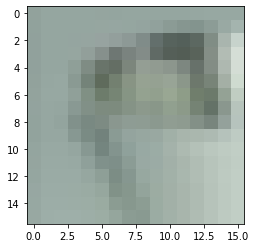

In [11]:
patches = img_to_patch(example_img, 16, flatten_channels=False)
patches.shape
plt.imshow(patches.squeeze()[0].permute(1,2,0))

In [18]:
patches.squeeze()[0].shape
patches2 = patches.squeeze()[0].permute(1,2,0).numpy()

In [19]:
patches2.shape

(16, 16, 3)

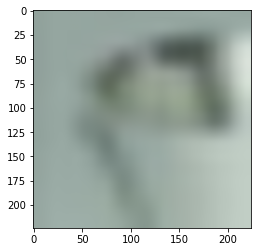

In [20]:
import cv2
newsize = (224, 224)
newimage = cv2.resize(patches2, dsize=newsize, interpolation=cv2.INTER_CUBIC)
plt.imshow(newimage)

In [65]:
del(train)
del(test)
del(val)

NameError: name 'train' is not defined

In [23]:
    def unpickle(file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

In [24]:
x = unpickle(f'{data_root}\\cifar-100-python\\train')

In [28]:
x.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

In [24]:
224*224*3

150528

In [3]:
from data_processing.glaucoma import GONRefuge
import os
from data_processing.transforms import *
import matplotlib.pyplot as plt
from data_processing.data_generator_approach_2 import DataGeneratorA2

%load_ext autoreload
%autoreload 2

repo_root = os.path.abspath(os.getcwd())
data_root = os.path.join(repo_root, "data")
#train = GONRefuge(root=data_root, purpose='train')#, transform=transforms)
patch_num = 8
transforms = [RescaleTransform(), Patches_new(patch_num=patch_num), Resize()]
batch_size = 4

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
test = GONRefuge(root=data_root, purpose='test', transform=transforms)

In [36]:
test_dataloader = DataGeneratorA2(test, batch_size=batch_size, flatten_batch=True)

In [37]:
batchtest = next(iter(test_dataloader))

In [39]:
batchtest['label'].shape

torch.Size([4, 64])

In [6]:
scaled_up = val[0]['image'][34].transpose(1,2,0)
scaled_down = val[1]['image'][25].transpose(1,2,0)

In [2]:
test[0]

{'image': array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          ...,
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
 
         [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, .

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


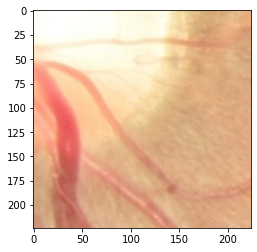

In [7]:
plt.imshow(scaled_up)

In [63]:
imgc['image'].shape

(64, 3, 224, 224)

In [37]:
250//8*8

248

In [23]:
val = GONRefuge(root=data_root, purpose='val')#, transform=transforms)

In [28]:
val[0]['image'].shape

(2056, 2124, 3)

In [1]:
    import os

    ## PyTorch
    import torch
    import torch.optim as optim

    from data_processing.glaucoma import GONRefuge
    from data_processing.data_generator_approach_2 import DataGeneratorA2
    from data_processing.transforms import *
    from approach_2.model import VisionTransformerEmbedded
    #from approach_1.attention_training import AttentionSolver


    hparams = {
        'batch_size': 8,
        'learning_rate': 1e-3,
        'epochs': 2,
        'loss_func': torch.nn.BCEWithLogitsLoss(),
        'optimizer': optim.AdamW
    }

    repo_root = os.path.abspath(os.getcwd())
    data_root = os.path.join(repo_root, "data")

    patch_size = 16 #this is not used either way
    num_patches = 2 #8
    num_classes = 2

    transforms = [RescaleTransform(), Patches_new(patch_num=num_patches), Resize()]
    train = GONRefuge(root=data_root, purpose='train', transform=transforms)
    val = GONRefuge(root=data_root, purpose='val', transform=transforms)

    train_dataloader = DataGeneratorA2(train, batch_size=hparams["batch_size"], flatten_batch=True)
    val_dataloader = DataGeneratorA2(val, batch_size=hparams["batch_size"], flatten_batch=True)

    model = VisionTransformerEmbedded(**{
                                    'embed_dim': 256,
                                    'hidden_dim': 512,
                                    'num_heads': 4,
                                    'num_layers': 2,
                                    'patch_size': patch_size,
                                    'num_patches': num_patches**2,
                                    'num_classes': num_classes,
                                    'dropout': 0.2,
                                    'hparams': hparams
                                })


In [9]:
m = torch.nn.Sigmoid()
loss = torch.nn.BCELoss()
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)

In [19]:
target = torch.ones([10, 64], dtype=torch.float32)  # 64 classes, batch size = 10
output = torch.full([10, 64], 1.5)  # A prediction (logit)
pos_weight = torch.ones([64])  # All weights are equal to 1
criterion = torch.nn.BCEWithLogitsLoss()
criterion(output, target)

tensor(0.2014)

In [43]:
loss = torch.nn.BCEWithLogitsLoss()
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)
output = loss(input, target)

In [18]:
output

tensor([[1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000],
        [1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1

In [12]:
target

tensor([1., 1., 1.])

In [2]:
example_batch = next(iter(train_dataloader))

In [3]:
predictions = model.forward(example_batch['image'])

In [39]:
predictions

tensor([[-0.0469, -0.9155],
        [-0.0263, -1.1087],
        [ 0.6828, -0.4129],
        [-0.1633, -0.5667],
        [-0.1658, -0.6414],
        [-0.1389, -0.9289],
        [ 0.4805, -0.3976],
        [ 0.2898, -0.8653]], grad_fn=<AddmmBackward>)

In [ ]:
predictions.sigmoid

In [40]:
a = torch.nn.Softmax(predictions[0], dim=2)

TypeError: __init__() got multiple values for argument 'dim'

In [42]:
import torch.nn.functional as F
F.softmax(predictions[1], dim=2)

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [36]:
a

Softmax(dim=tensor([-0.0469, -0.9155], grad_fn=<SelectBackward>))

In [55]:
predictions[:, 1]

tensor([-0.9155, -1.1087, -0.4129, -0.5667, -0.6414, -0.9289, -0.3976, -0.8653],
       grad_fn=<SelectBackward>)

In [29]:
torch.nn.Sigmoid(predictions[0][0])

TypeError: __init__() takes 1 positional argument but 2 were given

In [51]:
example_batch['label'][:, 0]

tensor([0, 1, 0, 0, 1, 0, 1, 0])

In [59]:
loss(predictions[:, 1], example_batch['label'][:, 0].float())

tensor(0.6685, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [58]:
predictions[:, 1]

tensor([-0.9155, -1.1087, -0.4129, -0.5667, -0.6414, -0.9289, -0.3976, -0.8653],
       grad_fn=<SelectBackward>)

In [5]:
import os

%load_ext autoreload
%autoreload 2

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

from data_processing.glaucoma import GONRefuge
from data_processing.data_generator_approach_2 import DataGeneratorA2
from data_processing.transforms import *
from approach_2.model import VisionTransformerEmbedded
from approach_2.glaucoma_training import GlaucomaSolver

if __name__ == "__main__":
    hparams = {
        'batch_size': 3, #5
        'learning_rate': 1e-4,
        'epochs': 10,
        'loss_func': torch.nn.BCEWithLogitsLoss(),
        'optimizer': optim.AdamW
    }

    repo_root = os.path.abspath(os.getcwd())
    data_root = os.path.join(repo_root, "data")

    patch_size = 16 #this is not used either way
    num_patches = 2 #8
    num_classes = 2

    transforms = [RescaleTransform(), Patches_new(patch_num=num_patches), Resize()]
    train = GONRefuge(root=data_root, purpose='train', transform=transforms)
    val = GONRefuge(root=data_root, purpose='val', transform=transforms)


    train_dataloader = DataGeneratorA2(train, batch_size=hparams["batch_size"], flatten_batch=True)
    # next(iter(train_dataloader))['image'].shpe -> torch.Size([3, 4, 3, 224, 224])
    val_dataloader = DataGeneratorA2(val, batch_size=hparams["batch_size"], flatten_batch=True)

    etc= next(iter(train_dataloader))
    print("shape")
    print(etc['image'].shape)
    model = VisionTransformerEmbedded(**{
                                    'embed_dim': 256,
                                    'hidden_dim': 512,
                                    'num_heads': 4,
                                    'num_layers': 2,
                                    'patch_size': patch_size,
                                    'num_patches': num_patches**2,
                                    'num_classes': num_classes,
                                    'dropout': 0.2,
                                    'hparams': hparams
                                })



    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    patience = 10


    solver = GlaucomaSolver(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        device=device,
        patience=patience
    )

    solver.train()


    #debug the remaining small batch!!!

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(3, 4, 3, 224, 224)
shape
torch.Size([3, 4, 3, 224, 224])
(3, 4, 3, 224, 224)
(3, 4, 3, 224, 224)


KeyboardInterrupt: 

In [1]:

import os
from datasets.siim import SIIM
from data_processing.transforms import *

%load_ext autoreload
%autoreload 2

repo_root = os.path.abspath(os.getcwd())
data_root = os.path.join(repo_root, "data/siim")

seed = 69
split = 0.7
transforms = [Patches(patch_num=8), Resize((3, 500, 750))]

train = SIIM(root=data_root, purpose='train', seed=seed, split=split, transform=transforms)

In [6]:
train.images.index('ISIC_0075663')
#ISIC_0015719
#ISIC_0052212
#ISIC_0075663

11780

In [7]:
our_batch = [train[8349], train[7959], train[11780]]

In [10]:
our_batch[0]['image'].shape

torch.Size([1, 64, 3, 500, 750])

In [11]:
our_batch[0]['label'].shape

torch.Size([1, 64])

In [13]:
batch_processed = build_batch(our_batch)

In [17]:
batch_processed['label'].shape

torch.Size([3, 64])

In [4]:
train[8349]['image'].shape
#train.images

e:\!LMU\PythonProjects\generaldsvenv\lib\site-packages\torch\nn\functional.py:3060: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


torch.Size([1, 64, 3, 500, 750])

In [3]:
    hparams = {
        'batch_size': 8,
        'learning_rate': 1e-3,
        'epochs': 2,
        #'loss_func': torch.nn.BCEWithLogitsLoss(),
        #'optimizer': optim.AdamW,
        'patch_num': 8,
        'new_size': (3, 400, 500)
    }
    from functools import reduce
    flattened_dim = reduce((lambda x, y: x * y), hparams['new_size'])

In [4]:
flattened_dim

600000

In [5]:
3*400*500

600000

In [13]:
from appr0_VIT.data_generator import DataGenerator
dg = DataGenerator(train, batch_size=4)

In [15]:
next(iter(dg))

0
1
2
3


RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:73] data. DefaultCPUAllocator: not enough memory: you tried to allocate 1152000000 bytes. Buy new RAM!

In [ ]:
dim=0
torch.Size([8, 1, 64, 3, 500, 750])

In [12]:
        def build_batch(batch):
            batch_dict = {
                'image': torch.stack([img['image'] for img in batch], dim=0).squeeze(),
                'label': torch.stack([img['label'] for img in batch], dim=0).squeeze()
            }
            return batch_dict

In [181]:
import os
from PIL import Image
import torch
from torchvision import transforms

repo_root = os.path.abspath(os.getcwd())
img_root = os.path.join(repo_root, "data/siim/ISIC_0015719.jpg")
img = Image.open(img_root)
trans = transforms.ToTensor()
img = trans(img)

%load_ext autoreload
%autoreload 2


FileNotFoundError: [Errno 2] No such file or directory: 'd:\\Workspace\\cv_attention\\data/siim/ISIC_0015719.jpg'

In [2]:
img.shape

torch.Size([3, 4000, 6000])

In [2]:
img_dict = {
    'image': img.unsqueeze(0),
    'label': torch.tensor([1])
}

In [30]:
img_dict['image'].shape

torch.Size([1, 64, 3, 500, 750])

In [3]:
from data_processing.transforms import *
rescale_trans = RescaleTransform()
patches_trans = Patches(8)
resize_trans = Resize((3, 1000, 1500), 'trilinear')

In [4]:
patches_trans(img_dict)
resize_trans(img_dict)

e:\!LMU\PythonProjects\generaldsvenv\lib\site-packages\torch\nn\functional.py:3060: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


{'image': tensor([[[[[0.5686, 0.5686, 0.5686,  ..., 0.7696, 0.7716, 0.7725],
            [0.5696, 0.5696, 0.5696,  ..., 0.7703, 0.7718, 0.7725],
            [0.5716, 0.5716, 0.5716,  ..., 0.7718, 0.7723, 0.7725],
            ...,
            [0.6176, 0.6186, 0.6206,  ..., 0.8373, 0.8412, 0.8431],
            [0.6216, 0.6225, 0.6245,  ..., 0.8373, 0.8412, 0.8431],
            [0.6235, 0.6245, 0.6265,  ..., 0.8373, 0.8412, 0.8431]],
 
           [[0.3412, 0.3412, 0.3412,  ..., 0.5304, 0.5324, 0.5333],
            [0.3422, 0.3422, 0.3422,  ..., 0.5311, 0.5326, 0.5333],
            [0.3441, 0.3441, 0.3441,  ..., 0.5326, 0.5331, 0.5333],
            ...,
            [0.3706, 0.3716, 0.3735,  ..., 0.6255, 0.6294, 0.6314],
            [0.3745, 0.3755, 0.3775,  ..., 0.6255, 0.6294, 0.6314],
            [0.3765, 0.3775, 0.3794,  ..., 0.6255, 0.6294, 0.6314]],
 
           [[0.1961, 0.1961, 0.1961,  ..., 0.4480, 0.4500, 0.4510],
            [0.1971, 0.1971, 0.1971,  ..., 0.4488, 0.4502, 0.4510],

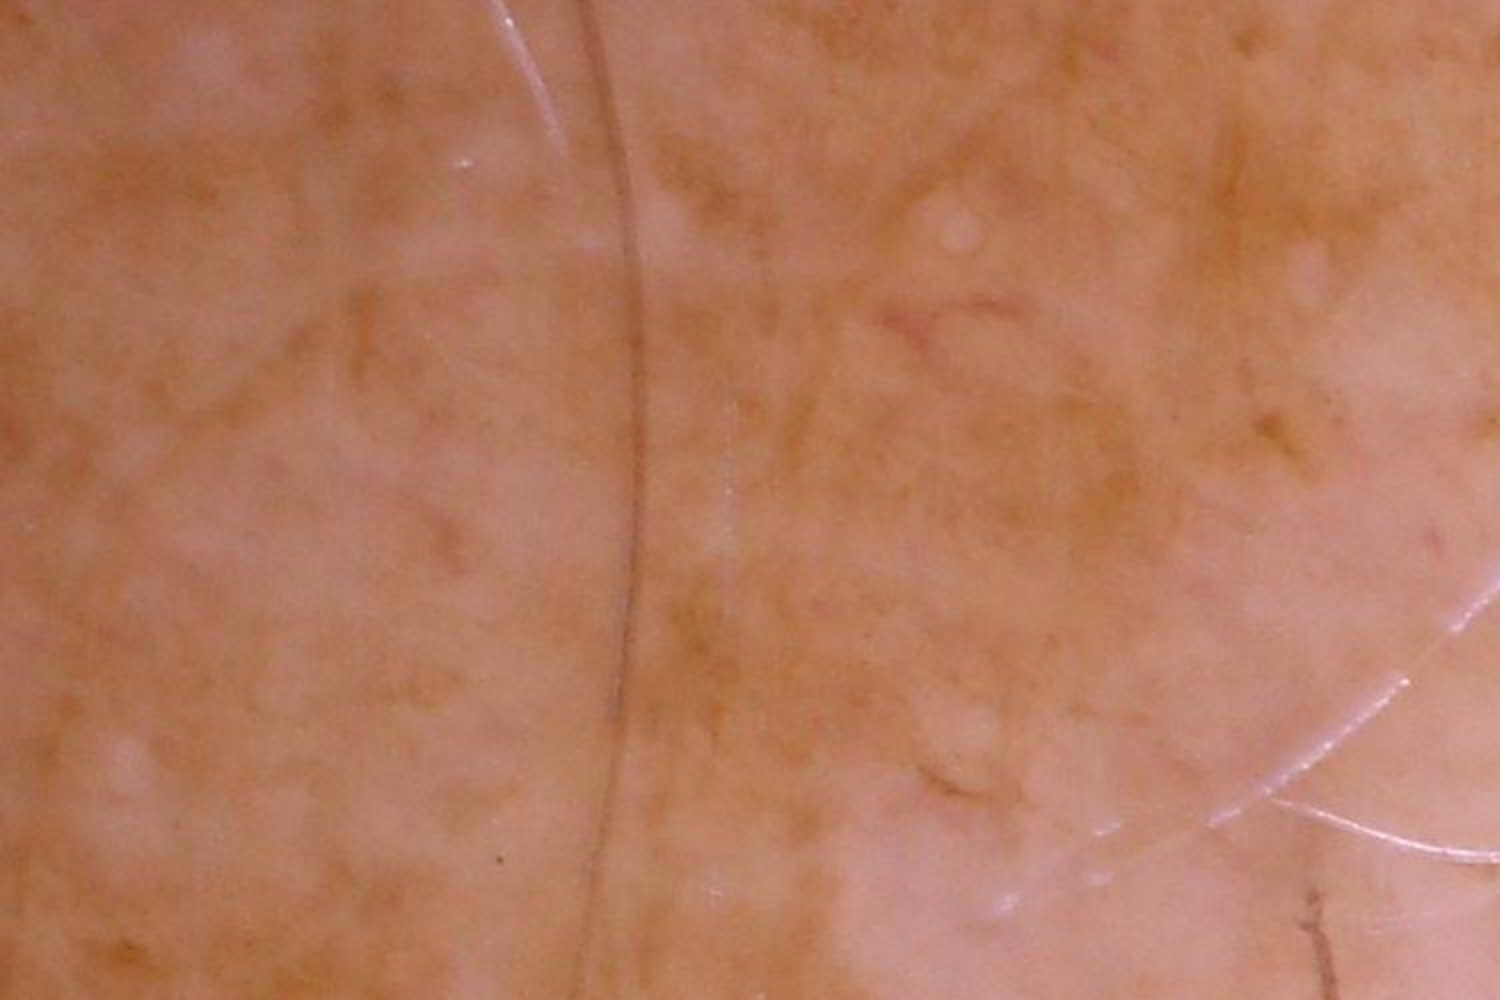

In [5]:
trans = transforms.ToPILImage()
pilimage = trans(img_dict['image'][0,0,:,:,:])
pilimage

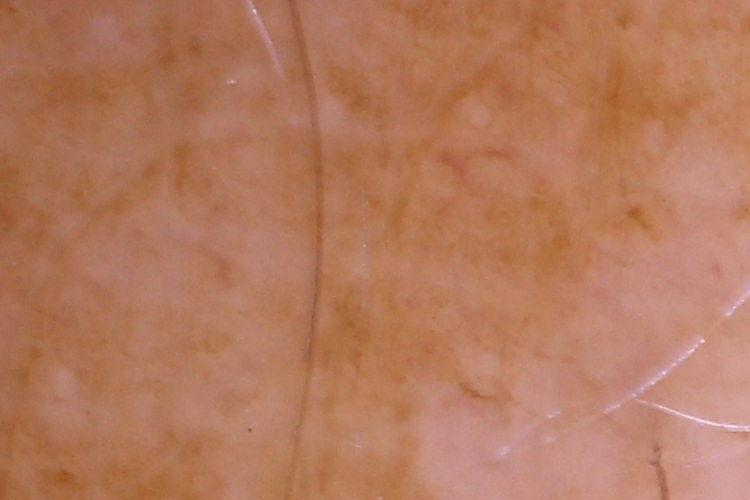

In [31]:
trans = transforms.ToPILImage()
pilimage = trans(img_dict['image'][0,0,:,:,:])
pilimage

In [14]:
img_dict['label'].shape

torch.Size([1, 64])

In [21]:
torch.full((2, 3), 3.141592)

tensor([[3.1416, 3.1416, 3.1416],
        [3.1416, 3.1416, 3.1416]])

In [ ]:
1024

In [1]:
224*224*3

150528

In [3]:
128*128*3

49152

In [5]:
16*16

256

In [6]:
2124*2056
1634*1634

4366944

In [22]:
112*112*3

37632

In [23]:
64*4*4

1024

In [ ]:
800x1500

In [ ]:
896*1344

In [25]:
896/224

4.0

In [17]:
1344/112

12.0

In [19]:
224*8

1792

In [18]:
12*8

96

In [8]:
224*6

1344

In [10]:
224*4

896

In [12]:
112*112*3

9408

708.0

In [2]:
32*32*3

3072

In [3]:
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
%load_ext autoreload
%autoreload 2
from data_processing.glaucoma import GONRefuge
from data_processing.data_generator import DataGenerator
from data_processing.transforms import *
from approach_1.models import BaselineResNet
from approach_2.glaucoma_training import GlaucomaSolver



if __name__ == "__main__":
    hparams = {
    'batch_size': 3,
    'learning_rate': 1e-3,
    'epochs': 2,
    'loss_func': torch.nn.BCEWithLogitsLoss(),
    'optimizer': optim.AdamW
    }

    num_classes = 2
    freeze=False
    patience = 3
    repo_root = os.path.abspath(os.getcwd())
    data_root = os.path.join(repo_root, "data")
    num_patches = 2 #8

    transforms = [RescaleTransform(), Patches_new(patch_num=num_patches), Resize()]
    # train = Cifar100(root=data_root, purpose='train', seed=seed, split=0.001, transform=transforms)
    # val = Cifar100(root=data_root, purpose='val', seed=seed, split=0.999, transform=transforms)

    train = GONRefuge(root=data_root, purpose='train', transform=transforms)
    val = GONRefuge(root=data_root, purpose='val', transform=transforms)


    train_dataloader = DataGenerator(train, batch_size=hparams['batch_size'])
    # next(iter(train_dataloader))['image'].shpe -> torch.Size([12 (patch x batch_size), 3, 224, 224])

    val_dataloader = DataGenerator(val, batch_size=hparams['batch_size'])
    model = BaselineResNet(num_classes=num_classes, hparams=hparams, freeze=freeze)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    solver = GlaucomaSolver(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        device=device,
        patience=patience,
        approach=1
    )

    solver.train()

    # os.makedirs('trained_models', exist_ok=True)
    # models_path = os.path.join(repo_root, 'trained_models')
    # model.save(os.path.join(models_path, f'baselinemodel_batch{hparams["batch_size"]}_lr{hparams["learning_rate"]}_epochs{hparams["epochs"]}_freeze{freeze}.model'))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
epoch train loss: 1.041268229484558
Training accuracy after epoch 1: 0.625
Validation accuracy after epoch 1: 0.42500001192092896
epoch train loss: 0.7579411864280701
Training accuracy after epoch 2: 0.5
Validation accuracy after epoch 2: 0.10000000149011612
FINISH.


In [21]:
ex = next(iter(train_dataloader))
ex['image'].shape

(2056, 2124, 3)


torch.Size([4, 3, 224, 224])

In [3]:
%load_ext autoreload
%autoreload 2


import os
import pytorch_lightning as pl
import torch
import time
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import csv
import pandas as pd
from functools import reduce
from time import time
import math

from datasets.siim import SIIM
from data_processing.transforms import *
from datasets.cifar_100 import Cifar100
from appr0_VIT.model import VisionTransformer
from appr0_VIT.solver import Solver
from appr0_VIT.cifar100_trainer import CIFAR100Trainer
from appr0_VIT.data_generator import DataGenerator
from losses import LDAMLoss, FocalLoss

if __name__ == "__main__":
    # DRW type produced cls weights with values 1. each.
    per_cls_weights = torch.FloatTensor([1.,1.])
    hparams = {
        'batch_size': 16,
        'learning_rate': 1e-3,
        'epochs': 3,
        'loss_func': nn.CrossEntropyLoss(),
        #'loss_func': torch.nn.BCEWithLogitsLoss(),
        #'loss_func':  FocalLoss(weight=per_cls_weights, gamma=2), #more val of gamma means more weight on the misclassified sampls
        'optimizer': optim.AdamW,
        'patch_num': 8,
        'new_size': (3, 32, 32)
    }

    repo_root = os.path.abspath(os.getcwd())
    model_root = os.path.join(repo_root, "trained_models")
    data_root = os.path.join(repo_root, "data")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    seed = 42
    split = 0.7
    num_classes = 20

    transforms = [Patches(patch_num=hparams['patch_num']), Resize(new_size=hparams['new_size'])]

    train = Cifar100(root=data_root, purpose='train', seed=seed, split=split, transform=transforms)
    val = Cifar100(root=data_root, purpose='val', seed=seed, split=split, transform=transforms)
    
    def collate_data(batch):
        batch_dict = {
            'image': torch.stack([img['image'] for img in batch], dim=0).squeeze(),
            'label': torch.stack([img['label'] for img in batch], dim=0).squeeze()
        }
        return batch_dict
    
    

    train_dataloader = DataLoader(dataset=train, batch_size=hparams["batch_size"], shuffle=True,collate_fn=lambda batch: collate_data(batch))
    val_dataloader = DataLoader(dataset=val, batch_size=hparams["batch_size"], shuffle=True,collate_fn=lambda batch: collate_data(batch))
    # # train_dataloader = DataGenerator(train, batch_size=hparams["batch_size"])
    # # val_dataloader = DataGenerator(val, batch_size=hparams["batch_size"])

    flattened_dim = reduce((lambda x, y: x * y), hparams['new_size'])

    model = VisionTransformer(**{
                                    'embed_dim': 256,
                                    'hidden_dim': 512,
                                    #'num_heads': 8,
                                    #'num_layers': 6,
                                    'num_heads': 4,
                                    'num_layers': 2,
                                    'flattened_dim': flattened_dim,
                                    'num_patches': hparams['patch_num']**2,
                                    'num_classes': num_classes,
                                    'dropout': 0.2,
                                    'hparams': hparams
                                })

    # patience = 20


    model = CIFAR100Trainer(model)

    trainer = pl.Trainer(accelerator="cpu",max_epochs=hparams['epochs'])
    trainer.fit(model, train_dataloader, val_dataloader)

    # %load_ext tensorboard
    # %tensorboard --logdir lightning_logs/
    
    #trainer.test()

    # solver = Solver(
    #     model=model,
    #     train_dataloader=train_dataloader,
    #     val_dataloader=val_dataloader,
    #     device=device,
    #     patience=patience
    # )

    # solver.train()

    # ########## SAVE MODEL ##########
    # os.makedirs('trained_models', exist_ok=True)
    # models_path = os.path.join(repo_root, 'trained_models')
    # model_name = f'vitmodel_batch{hparams["batch_size"]}_lr{hparams["learning_rate"]}_epochs{hparams["epochs"]}_{math.floor(time())}'
    # model.save(os.path.join(models_path, f'{model_name}.model'))

    # ########## SAVE STATISTICS ##########
    # measurements = {
    #     'epoch': [i+1 for i in range(len(solver.train_loss_history))],
    #     'train_loss': solver.train_loss_history,
    #     'val_loss': solver.val_loss_history,
    #     'train_TP': solver.train_TP_history,
    #     'train_FP': solver.train_FP_history,
    #     'train_TN': solver.train_TN_history,
    #     'train_FN': solver.train_FN_history,
    #     'val_TP': solver.val_TP_history,
    #     'val_FP': solver.val_FP_history,
    #     'val_TN': solver.val_TN_history,
    #     'val_FN': solver.val_FN_history,
    # }

    # measurements = pd.DataFrame(measurements)
    # measurements['train_accuracy'] = (measurements['train_TP'] + measurements['train_TN']) / (measurements['train_TP'] + measurements['train_TN'] + measurements['train_FP'] + measurements['train_FN'])
    # measurements['train_recall'] = measurements['train_TP'] / (measurements['train_TP'] + measurements['train_FN'])
    # measurements['train_precision'] = measurements['train_TP'] / (measurements['train_TP'] + measurements['train_FP'])
    # measurements['train_f1'] = 2 * (measurements['train_recall'] * measurements['train_precision']) / (measurements['train_recall'] + measurements['train_precision'])
    # measurements['val_accuracy'] = (measurements['val_TP'] + measurements['val_TN']) / (measurements['val_TP'] + measurements['val_TN'] + measurements['val_FP'] + measurements['val_FN'])
    # measurements['val_recall'] = measurements['val_TP'] / (measurements['val_TP'] + measurements['val_FN'])
    # measurements['val_precision'] = measurements['val_TP'] / (measurements['val_TP'] + measurements['val_FP'])
    # measurements['val_f1'] = 2 * (measurements['val_recall'] * measurements['val_precision']) / (measurements['val_recall'] + measurements['val_precision'])

    # measurements.to_csv(os.path.join(models_path, f'{model_name}.csv'), sep='|')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type              | Params
------------------------------------------------
0 | model     | VisionTransformer | 1.9 M 
1 | loss_func | CrossEntropyLoss  | 0     
------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.454     Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]torch.Size([16, 20])
tensor([ 3, 19, 14,  9, 12, 14, 16,  6, 14, 16, 15,  4, 19,  7, 13,  2])
torch.Size([16])
Validation sanity check:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s]torch.Size([16, 20])
tensor([ 1, 15,  0, 19, 19,  8,  7,  4,  3,  7,  8, 14,  9, 12,  5,  4])
torch.Size([16])
Epoch 0:   0%|          | 0/3126 [00:00<?, ?it/s]                     tensor([[ 1.2132e-01, -2.8359e-01,  4.5956e-01, -2.7133e-01, -7.5737e-01,
         -5.5591e-01, -1.2789e-01, -4.3332e-03, -1.1968e+00,  3.7497e-01,
          1.8853e-01,  9.0057e-01,  2.1929e-03, -5.1698e-01,  6.2037e-02,
          2.9156e-01, -9.6488e-02,  1.1589e+00,  4.0810e-01, -3.2569e-01],
        [ 3.2717e-01,  4.1712e-01,  3.3745e-01, -1.4249e-01, -1.9855e-01,
         -1.2755e-01,  2.4404e-01,  2.5534e-01, -1.0666e+00,  2.0232e-01,
          6.5978e-01,  1.1844e+00,  1.0189e-01, -5.3128e-01, -1.9301e-01,
         -3.9434e-01, -8.4911e-02,  7.2746e-01,  6.0780e-

c:\Users\HP\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:686: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [12]:
%load_ext autoreload
%autoreload 2


import os
import pytorch_lightning as pl
import torch
import time
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import csv
import pandas as pd
from functools import reduce
from time import time
import math
import torchvision.transforms as transforms
from datasets.siim import SIIM
from data_processing.transforms import *

from appr0_VIT.model import VisionTransformer
from appr0_VIT.solver import Solver
from appr0_VIT.siim_trainer import SIIMTrainer
from appr0_VIT.data_generator import DataGenerator
from losses import LDAMLoss, FocalLoss

if __name__ == "__main__":
    # DRW type produced cls weights with values 1. each.
    per_cls_weights = torch.FloatTensor([1.,1.])
    pos_weight  = 32542 / 584
    pos_weight = torch.as_tensor(pos_weight, dtype=torch.float)
    hparams = {
        'batch_size': 16,
        'learning_rate': 1e-3,
        'epochs': 3,
        #'loss_func': torch.nn.BCEWithLogitsLoss(pos_weight= pos_weight),
        'loss_func':  FocalLoss(gamma=15), #more val of gamma means more weight on the misclassified sampls
        'optimizer': optim.AdamW,
        'patch_num': 8,
        'new_size': (3, 400, 500)
    }

    repo_root = os.path.abspath(os.getcwd())
    model_root = os.path.join(repo_root, "trained_models")
    data_root = os.path.join(repo_root, "data/siim")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    seed = 42
    split = 0.7
    num_classes = 2

    transforms = transforms.Compose([
     #transforms.ToPILImage(),
     #transforms.Resize((300, 300)),
     transforms.CenterCrop((100, 100)),
     transforms.ColorJitter(brightness=0.7, contrast=0.7, saturation=0.7, hue=0.5),
     transforms.RandomGrayscale(p=0.7),
     transforms.RandomVerticalFlip(p=0.7),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

    # transform = transforms.Compose([
    #     transforms.ToTensor(),
    #     Patches(patch_num=hparams['patch_num']), Resize(new_size=hparams['new_size'])
    # ])

    tfm_on_patch = [Patches(patch_num=hparams['patch_num']), Resize(new_size=hparams['new_size'])]

    train = SIIM(root=data_root, purpose='train', seed=seed, split=split, transforms=transforms, tfm_on_patch=tfm_on_patch)
    val = SIIM(root=data_root, purpose='val', seed=seed, split=split, transforms=transforms, tfm_on_patch=tfm_on_patch)
    
    def collate_data(batch):
        batch_dict = {
            'image': torch.stack([img['image'] for img in batch], dim=0).squeeze(1),
            'label': torch.stack([img['label'] for img in batch], dim=0).squeeze()
        }
        return batch_dict

    train_dataloader = DataLoader(dataset=train, batch_size=hparams["batch_size"], shuffle=True,collate_fn=lambda batch: collate_data(batch))
    val_dataloader = DataLoader(dataset=val, batch_size=hparams["batch_size"], shuffle=True,collate_fn=lambda batch: collate_data(batch))

    # train_dataloader = DataGenerator(train, batch_size=hparams["batch_size"])
    # val_dataloader = DataGenerator(val, batch_size=hparams["batch_size"])

    flattened_dim = reduce((lambda x, y: x * y), hparams['new_size'])

    model = VisionTransformer(**{
                                    'embed_dim': 256,
                                    'hidden_dim': 512,
                                    #'num_heads': 8,
                                    #'num_layers': 6,
                                    'num_heads': 4,
                                    'num_layers': 2,
                                    'flattened_dim': flattened_dim,
                                    'num_patches': hparams['patch_num']**2,
                                    'num_classes': num_classes,
                                    'dropout': 0.2,
                                    'hparams': hparams
                                })

    patience = 20


    model = SIIMTrainer(model)

    trainer = pl.Trainer(accelerator="cpu",max_epochs=hparams['epochs'])
    trainer.fit(model, train_dataloader, val_dataloader)
    # %load_ext tensorboard
    # %tensorboard --logdir lightning_logs/
    
    #trainer.test()

    # solver = Solver(
    #     model=model,
    #     train_dataloader=train_dataloader,
    #     val_dataloader=val_dataloader,
    #     device=device,
    #     patience=patience
    # )

    # solver.train()

    # ########## SAVE MODEL ##########
    # os.makedirs('trained_models', exist_ok=True)
    # models_path = os.path.join(repo_root, 'trained_models')
    # model_name = f'vitmodel_batch{hparams["batch_size"]}_lr{hparams["learning_rate"]}_epochs{hparams["epochs"]}_{math.floor(time())}'
    # model.save(os.path.join(models_path, f'{model_name}.model'))

    # ########## SAVE STATISTICS ##########
    # measurements = {
    #     'epoch': [i+1 for i in range(len(solver.train_loss_history))],
    #     'train_loss': solver.train_loss_history,
    #     'val_loss': solver.val_loss_history,
    #     'train_TP': solver.train_TP_history,
    #     'train_FP': solver.train_FP_history,
    #     'train_TN': solver.train_TN_history,
    #     'train_FN': solver.train_FN_history,
    #     'val_TP': solver.val_TP_history,
    #     'val_FP': solver.val_FP_history,
    #     'val_TN': solver.val_TN_history,
    #     'val_FN': solver.val_FN_history,
    # }

    # measurements = pd.DataFrame(measurements)
    # measurements['train_accuracy'] = (measurements['train_TP'] + measurements['train_TN']) / (measurements['train_TP'] + measurements['train_TN'] + measurements['train_FP'] + measurements['train_FN'])
    # measurements['train_recall'] = measurements['train_TP'] / (measurements['train_TP'] + measurements['train_FN'])
    # measurements['train_precision'] = measurements['train_TP'] / (measurements['train_TP'] + measurements['train_FP'])
    # measurements['train_f1'] = 2 * (measurements['train_recall'] * measurements['train_precision']) / (measurements['train_recall'] + measurements['train_precision'])
    # measurements['val_accuracy'] = (measurements['val_TP'] + measurements['val_TN']) / (measurements['val_TP'] + measurements['val_TN'] + measurements['val_FP'] + measurements['val_FN'])
    # measurements['val_recall'] = measurements['val_TP'] / (measurements['val_TP'] + measurements['val_FN'])
    # measurements['val_precision'] = measurements['val_TP'] / (measurements['val_TP'] + measurements['val_FP'])
    # measurements['val_f1'] = 2 * (measurements['val_recall'] * measurements['val_precision']) / (measurements['val_recall'] + measurements['val_precision'])

    # measurements.to_csv(os.path.join(models_path, f'{model_name}.csv'), sep='|')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type              | Params
------------------------------------------------
0 | model     | VisionTransformer | 154 M 
1 | loss_func | FocalLoss         | 0     
------------------------------------------------
154 M     Trainable params
0         Non-trainable params
154 M     Total params
618.690   Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
Epoch 0:   0%|          | 0/3 [00:00<?, ?it/s]                        torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size

In [12]:
import math
import torch
arrr = [ 0.0427,  0.0302, -0.2120,  0.5556, -0.4318,  0.2365, -0.1612, -0.2086,
          0.1978,  0.5976,  0.5736,  0.2222,  0.3607,  0.1218, -0.2665, -0.7624,
          0.0438, -1.1465, -0.2717,  1.1317]

#opts from c10 implm. github          
arr2 = [-0.2856, -0.9250, -1.0534, -0.3403, -0.6940,  0.4310, -0.3834,  0.4818,
         0.5968,  0.0626]
def logit2prob(logit):
    odds =  math.exp(logit)
    prob = odds / (1 + odds)
    return prob
ne = []
for i in arr2:
    ne.append(logit2prob(i))
sum(arr2)
          

tensor(0)

In [16]:
a=[4,5,73,24,78,89,[23,9]]

a[-1:]

'bab'

In [4]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 5084), started 0:00:13 ago. (Use '!kill 5084' to kill it.)

SyntaxError: invalid syntax (<ipython-input-11-ffee8368a325>, line 1)